## Use the link below to download datasets I used on my project  
[Download Datasets](https://drive.google.com/drive/folders/13roH6odMdpuZMhbmareG8zxQKEJ5I6Yz?usp=drive_link)

#### I encountered difficulties uploading my code along with the accompanying datasets for the project due to the substantial size of the datasets.
#### Download the image datasets in a folder from the provided link
#### Save the datasets in a folder within the project directory

## Data Preprocessing 
#### Clean the dataset by removing irrelevant or corrupted images.


In [12]:
from PIL import Image
import os
import cv2

dataset_dir = "C:\\Users\\bida20-016\Desktop\\Chest X-ray Analysis for Disease Detection\\data"
image_exts = ['jpeg', 'jpg', 'png']

for image_class in os.listdir(dataset_dir):
    print('Processing images from class {}'.format(image_class))
    class_dir = os.path.join(dataset_dir, image_class)
    if not os.path.isdir(class_dir):
        print('Skipping class directory {}'.format(class_dir))
        continue
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        if not os.path.isfile(image_path):
            print('Skipping non-image file {}'.format(image_path))
            continue
        try:
            img = cv2.imread(image_path)
            try:
                ext = os.path.splitext(image_path)[1][1:].lower()  # Get the file extension
                if ext not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
                else:
                    Image.open(image_path)  # Open the image to check if it is valid
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Error opening image {}'.format(image_path))
            continue

print('Image preprocessing complete.')


Processing images from class Emphysema
Processing images from class Normal
Processing images from class Pneumonia
Processing images from class Tuberculosis
Image preprocessing complete.


## Data Splitting 
#### Resize images to a consistent size.
#### Check for and handle class imbalances if present.
#### Split dataset into 80% train, 10% validation and 10% test sets


In [13]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to your dataset directory
dataset_dir = "C:\\Users\\bida20-016\\Desktop\\Chest X-ray Analysis for Disease Detection\\data"

# Set the paths to your train, validation, and test directories
train_data_dir = 'C:\\Users\\bida20-016\\Desktop\\Chest X-ray Analysis for Disease Detection\\train'
validation_data_dir = 'C:\\Users\\bida20-016\\Desktop\\Chest X-ray Analysis for Disease Detection\\validation'
test_data_dir = 'C:\\Users\\bida20-016\\Desktop\\Chest X-ray Analysis for Disease Detection\\test'

# Check if the directories already exist
if not os.path.exists(train_data_dir):
    print(f"Creating directory: {train_data_dir}")
    os.makedirs(train_data_dir)

if not os.path.exists(validation_data_dir):
    print(f"Creating directory: {validation_data_dir}")
    os.makedirs(validation_data_dir)

if not os.path.exists(test_data_dir):
    print(f"Creating directory: {test_data_dir}")
    os.makedirs(test_data_dir)

# Set the desired image size for resizing
image_size = (224, 224)

# Iterate over the classes in the dataset directory
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)

    if not os.path.isdir(class_dir):
        continue  # Skip non-directory entries

    # Get the list of image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if len(image_files) < 2:
        print(f"Skipping class '{class_name}' due to insufficient images.")
        continue

    # Split the class images into training, validation, and test sets
    train_class_files, temp_test_files = train_test_split(
        image_files,
        test_size=0.2,  # 80% for training, 20% for validation and test
        random_state=42
    )
    
    validation_class_files, test_class_files = train_test_split(
        temp_test_files,
        test_size=0.5,  # Split the remaining 20% into 10% for validation and 10% for test
        random_state=42
    )

    # Iterate over training, validation, and test sets
    for set_type, set_files in zip(['train', 'validation', 'test'], [train_class_files, validation_class_files, test_class_files]):
        set_data_dir = train_data_dir if set_type == 'train' else validation_data_dir if set_type == 'validation' else test_data_dir

        # Check if the directory for the class exists
        class_set_dir = os.path.join(set_data_dir, class_name)
        if not os.path.exists(class_set_dir):
            print(f"Creating directory: {class_set_dir}")
            os.makedirs(class_set_dir)

        # Process and move the images
        for img_name in set_files:
            src_path = os.path.join(class_dir, img_name)
            dst_path = os.path.join(set_data_dir, class_name, f"{class_name}_{set_type}_{img_name}")

            # Open the image using PIL
            img = Image.open(src_path)

            # Resize the image
            img = img.resize(image_size)

            # Convert the image to numpy array and normalize by dividing by 255
            img_array = np.array(img, dtype=np.float32) / 255.0

            # Save the preprocessed image with a new filename
            img_pil = Image.fromarray(np.uint8(img_array * 255.0))
            img_pil.save(dst_path)

print('Image processing and dataset split complete.')


Image processing and dataset split complete.


## Model Selection

In [14]:
# Importing necessary modules from TensorFlow and Keras for building a neural network using VGG16 architecture.
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

In [15]:
# Load the VGG16 pre-trained model with ImageNet weights, excluding the top classification layers.
# This is done to utilize the convolutional base of VGG16 for feature extraction while excluding the dense layers
# typically used for ImageNet classification. The 'include_top=False' argument ensures that only the convolutional
# layers are loaded. The 'weights' parameter specifies the use of pre-trained ImageNet weights.
# The 'input_shape' parameter sets the expected input shape of the images to (224, 224, 3).
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modify the usage of tf.nn.max_pool to tf.nn.max_pool2d in the base_model layers
for layer in base_model.layers:
    if 'MaxPooling2D' in str(type(layer)):
        layer.__class__ = tf.keras.layers.MaxPooling2D


In [16]:
# Freeze the base layers of the VGG16 model.
# By setting the 'trainable' attribute to False for each layer in the base model,
# we prevent these layers from being updated during the training of the subsequent layers.
for layer in base_model.layers:
    layer.trainable = False

## Model Customization

In [17]:
# Add custom classification layers on top of the frozen VGG16 base layers
# These layers are responsible for adapting the pre-trained features to the specific task

x = base_model.output  
x = Flatten()(x)  
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)  

In [18]:
# Define the number of classes for the final output layer
# Add the final output layer with 'softmax' activation for classification
num_classes = 4
output = Dense(num_classes, activation='softmax')(x)

In [19]:
# Create a new model by combining the VGG16 base model and custom classification layers
model = Model(inputs=base_model.input, outputs=output)


## Compile the model

In [20]:
# Compile the model with the specified optimizer, loss function, and evaluation metric
learning_rate = 0.003  
optimizer = SGD(learning_rate=learning_rate)  
loss_function = tf.compat.v1.losses.sparse_softmax_cross_entropy  # Use the deprecated loss function
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])


## Data Augumentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters using ImageDataGenerator.
# These parameters introduce random transformations to the training images,enhancing the model's ability 
# to generalize to variations in the input data.
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Set the batch size for training data batches.
batch_size = 64

# Generate batches of training data using the defined ImageDataGenerator.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 14076 images belonging to 4 classes.


## Training

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy


# Set hyperparameters for training the model.
learning_rate = 0.003
batch_size = 64
num_epochs = 15

# Define a sequential model for the CNN architecture.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  
])

# Compile the model with Stochastic Gradient Descent (SGD) optimizer,
# Categorical Crossentropy as the loss function, and accuracy as the metric.
optimizer = SGD(learning_rate=learning_rate)
loss_function = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Create an instance of the ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Generate batches of training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Train the model using a nested loop structure, iterating over epochs and batches.
for epoch in range(num_epochs):
    for i in range(len(train_generator)):
        # Generate a batch of training data using the specified data generator.
        batch_images, batch_labels = train_generator.next()

        # Use a GradientTape to record operations for automatic differentiation.
        with tf.GradientTape() as tape:
            # Forward pass: compute predictions and calculate the loss.
            predictions = model(batch_images, training=True)
            loss = loss_function(batch_labels, predictions)

        # Backpropagation: compute gradients and update model parameters.
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Print training progress after each epoch.
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} - Accuracy: {model.evaluate(train_generator)[1]:.4f}")
    



Found 14076 images belonging to 4 classes.


220/220 [==============================] - 1221s 5s/step - loss: 0.9994 - accuracy: 0.5793
Epoch 1/15 - Loss: 0.9456 - Accuracy: 0.5793
220/220 [==============================] - 631s 3s/step - loss: 0.9946 - accuracy: 0.5812
Epoch 2/15 - Loss: 0.9301 - Accuracy: 0.5812
220/220 [==============================] - 610s 3s/step - loss: 0.7270 - accuracy: 0.7099
Epoch 3/15 - Loss: 0.7411 - Accuracy: 0.7099
220/220 [==============================] - 288s 1s/step - loss: 0.7108 - accuracy: 0.7150
Epoch 4/15 - Loss: 0.6110 - Accuracy: 0.7150
220/220 [==============================] - 3059s 14s/step - loss: 0.6439 - accuracy: 0.7399
Epoch 5/15 - Loss: 0.6251 - Accuracy: 0.7399
220/220 [==============================] - 4793s 22s/step - loss: 0.6329 - accuracy: 0.7383
Epoch 6/15 - Loss: 0.7245 - Accuracy: 0.7383
220/220 [==============================] - 4286s 19s/step - loss: 0.5994 - accuracy: 0.7591
Epoch 7/15 - Loss: 0.6303 - Accuracy: 0.7591
220

## Fine-Tunning

In [12]:
# Fine-tune the model by unfreezing a specified number of upper layers in the base model.
# Iterate over the layers of the base model and unfreeze the specified number of upper layers.
num_layers_to_unfreeze = 4
for layer in base_model.layers[:-num_layers_to_unfreeze]:
    layer.trainable = False

# Print the summary of the base model to verify the changes.
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model with a smaller learning rate and momentum for fine-tuning.
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_fine_tuned_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False  # No need to shuffle for validation
)


# Continue training the model with the new dataset and validation data.
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)


Found 1759 images belonging to 4 classes.
Epoch 1/15
219/219 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8020

c:\Users\bida20-016\Desktop\Chest X-ray Analysis for Disease Detection\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 949s 4s/step - loss: 0.5188 - accuracy: 0.8020 - val_loss: 0.4569 - val_accuracy: 0.8166
Epoch 2/15
219/219 [==============================] - 996s 4s/step - loss: 0.5007 - accuracy: 0.8069 - val_loss: 0.4064 - val_accuracy: 0.8478
Epoch 3/15
219/219 [==============================] - 830s 4s/step - loss: 0.4841 - accuracy: 0.8139 - val_loss: 0.3816 - val_accuracy: 0.8623
Epoch 4/15
219/219 [==============================] - 778s 4s/step - loss: 0.4592 - accuracy: 0.8230 - val_loss: 0.3921 - val_accuracy: 0.8553
Epoch 5/15
219/219 [==============================] - 517s 2s/step - loss: 0.4549 - accuracy: 0.8264 - val_loss: 0.3800 - val_accuracy: 0.8588
Epoch 6/15
219/219 [==============================] - 4562s 21s/step - loss: 0.4425 - accuracy: 0.8295 - val_loss: 0.4028 - val_accuracy: 0.8414
Epoch 7/15
219/219 [==============================] - 3841s 18s/step - loss: 0.4286 - accuracy: 0.8360 - val_loss: 0.4054 - val_accuracy: 0.8380
Epoch 

## Evaluation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set the path to your test data directory
test_data_dir = 'C:\\Users\\bida20-016\\Desktop\\Chest X-ray Analysis for Disease Detection\\test'

# Create an ImageDataGenerator for test data with VGG16 preprocessing.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create a test data generator using the specified ImageDataGenerator settings.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle for testing
)

# Convert labels to int32 (if needed)
test_generator.classes = test_generator.classes.astype('int32')

# Evaluate the model on the testing set using the test data generator.
# Use the 'evaluate' method to obtain the testing loss and accuracy.
loss, accuracy = model.evaluate(test_generator)

# Print the testing results.
print("Testing Loss:", loss)
print("Testing Accuracy:", accuracy)


## Model Performance Metrics

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels from the test generator
true_labels = test_generator.classes

# Predict labels using the model
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

# Display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)


56/56 [==============================] - 689s 12s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       874
           1       0.52      0.07      0.12       970
           2       0.26      0.98      0.40       856
           3       0.43      0.06      0.10       822

    accuracy                           0.27      3522
   macro avg       0.55      0.28      0.16      3522
weighted avg       0.55      0.27      0.16      3522

Confusion Matrix:
 [[  2  12 834  26]
 [  0  64 882  24]
 [  0   4 838  14]
 [  0  42 732  48]]


## Confusion Matrix Heatmap

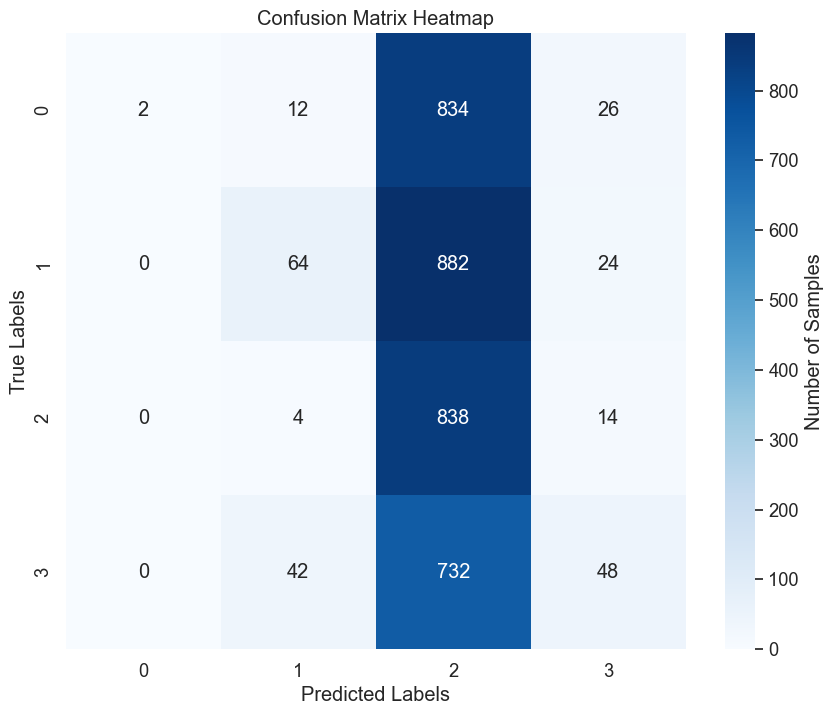

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Create a figure with a specific size
plt.figure(figsize=(10, 8))

# Generate a heatmap from the confusion matrix
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Number of Samples'})

# Set labels and title
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")
heatmap.set_title("Confusion Matrix Heatmap")

# Display the plot
plt.show()


## Training and Validation Loss, Accuracy graphs

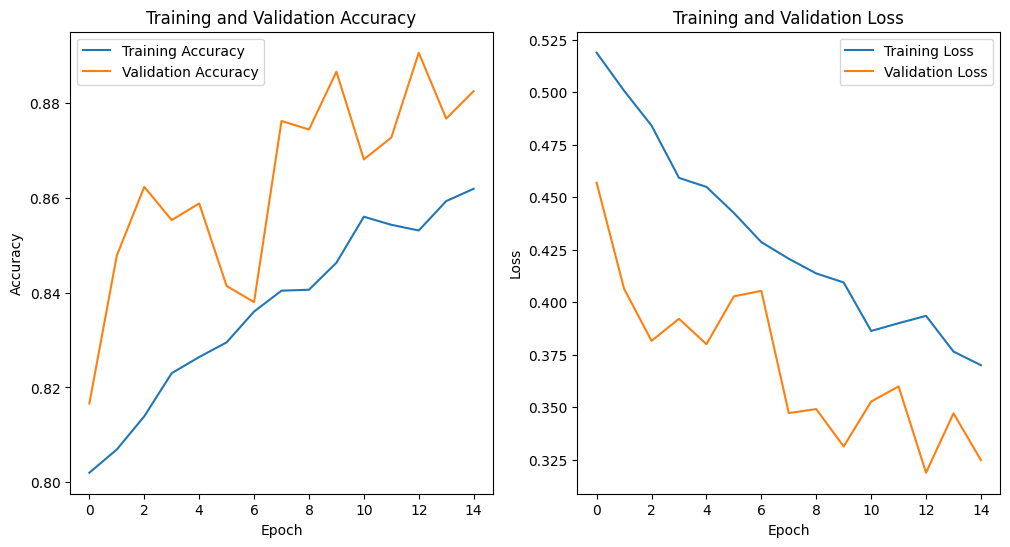

In [14]:
import matplotlib.pyplot as plt

# Create the history dictionary using model training/validation accuracy and loss output
history = {
    'accuracy': [0.8020, 0.8069, 0.8139, 0.8230, 0.8264, 0.8295, 0.8360, 0.8404, 0.8406, 0.8463, 0.8560, 0.8543, 0.8531, 0.8593, 0.8619],
    'val_accuracy': [0.8166, 0.8478, 0.8623, 0.8553, 0.8588, 0.8414, 0.8380, 0.8762, 0.8744, 0.8866, 0.8681, 0.8727, 0.8906, 0.8767, 0.8825],
    'loss': [0.5188, 0.5007, 0.4841, 0.4592, 0.4549, 0.4425, 0.4286, 0.4207, 0.4137, 0.4094, 0.3863, 0.3900, 0.3935, 0.3765, 0.3700],
    'val_loss': [0.4569, 0.4064, 0.3816, 0.3921, 0.3800, 0.4028, 0.4054, 0.3472, 0.3491, 0.3313, 0.3527, 0.3599, 0.3188, 0.3471, 0.3248]
}

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
